<img style="float: right;" src="http://www2.le.ac.uk/liscb1.jpg">  
# Leicester Institute of Structural and Chemical Biology: Python for Biochemists
# Curve fitting

Scipy is the first place to look for general-purpose scientific functionality.  The Scipy library is enormous and varied, so covering all the features is a course unto itself.  Having said that, one of the most commonly used features in scipy is it's fitting routines, which we will now explore.

## Simple Curve fitting

Scipy comes with a number of fitting routines.  One that can be extremely useful is `curve_fit`, which fits a function to a given set of data using a least-squares minimization.  Here, we'll fit some (made up) enzyme kinetics data to the Michaelis-Menten equation:  

$$\large V = \frac{V_{max}[S]}{K_m+[S]}$$  

Where $V$ is the initial rate of the reaction, $V_{max}$ is the rate of the reaction with infinite substrate concentration, $[S]$ is the substrate concentration and ${K_m}$ is the so-called *Michaelis* constant.

First, we define the Michaelis-Menten equation:

In [1]:
def michaelis_menten(s, km, vmax):
    return (vmax*s) / (km + s)

Now we pick some substrate concentrations we (would) do our measurements at:

In [2]:
import numpy as np

In [3]:
substrate_concentrations = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3])

For convenience when plotting, we'll create a numpy array of 1000 values between 0 and 3 for our x-axis:

In [4]:
substrate_concentration_range = np.linspace(0, 3, 1000)

Ok, lets make sure this looks right:

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

(0.0, 0.6)

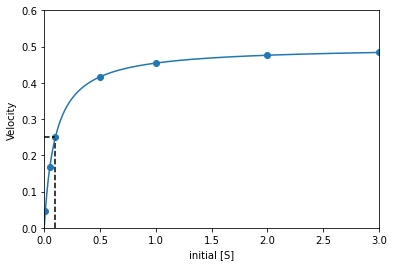

In [6]:
km = 0.1
vmax = 0.5

initial_velocities = michaelis_menten(s=substrate_concentrations, km=km, vmax=vmax)
mm_curve = michaelis_menten(substrate_concentration_range, km, vmax)


# Plot all the things!
plt.scatter(substrate_concentrations, initial_velocities)
plt.plot(substrate_concentration_range, mm_curve)

plt.ylabel('Velocity')
plt.xlabel('initial [S]')

# In M-M kinetics, the Km is the substrate concentration where you've reached half-max rate
plt.vlines(km, ymin=0, ymax=vmax/2, linestyle='dashed')
plt.hlines(vmax/2, xmin=0, xmax=km, linestyle='dashed')

plt.xlim(xmin=0, xmax=3)
plt.ylim(ymin=0, ymax=0.6)

Ok, so lets now simulate some noisy data (with Normally distributed noise):

In [7]:
number_of_concentrations = len(substrate_concentrations)
noise = (np.random.normal(loc=1, scale=0.1, size=number_of_concentrations))
simulated_data = michaelis_menten(substrate_concentrations, km, vmax)
simulated_noisy_data = simulated_data * noise

ok, so how does our simulation look?

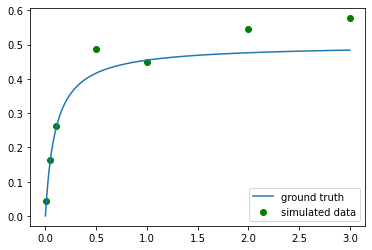

In [8]:
plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.legend(loc='lower right');

Now we can try to fit our original equation.  In order to do this, we need to provide a guess for the parameters that the algorithm can start from.  For something as simple as the M-M equation, even quite bad guesses will do.

In [9]:
initial_guess = (100, simulated_noisy_data[-1])  # Km and Vmax.  Note the Km is a truly horrible guess, given our data

In addition, we can provide the fitting algorithm with bounds - regions of allowed values for the parameters.  In this case, it's not necissary, but it's always good to have a sanity check (in this case, both parameters must be positive.)

In [10]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax

In [11]:
from scipy.optimize import curve_fit

fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
print('Km:', fitted[0])
print('Vmax:',fitted[1])

Km: 0.12155177348642754
Vmax: 0.5721582864134699


Remember, always look at your data as much as possible!

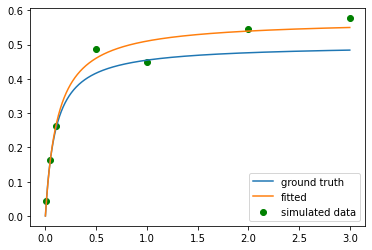

In [13]:
calculated_curve = michaelis_menten(substrate_concentration_range, fitted[0], fitted[1])

plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='fitted')

plt.legend(loc='lower right');

### Exercise 1: Did the fitting actually work?
The easiest way to see if the fitting function returned sensible values is not to just look at the curves!  Instead, the best way is to randomize the starting point. If it keeps giving the same numbers from various starting positions, it's more likely you can trust the results.
1. Generate a random starting value for $K_m$ from 0.01 to 10, and for $V_{max}$ from 0.01 to 10.  *Hint: use `random.uniform()`
2. Fit using these starting values and print both the starting value and resulting parameters.
3. Repeat for 10 total fits.  How does it look?

In [14]:
import random
random.uniform?

In [15]:
for _ in range(10):
    initial_guess = (random.uniform(0.01, 10), random.uniform(0.01, 10))
    fitted, covariance = curve_fit(f=michaelis_menten,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds, upper_bounds)
                              )
    print('Km: {:0.4}, Vmax: {:0.4} from initial guess: ({:0.3},{:0.3})'.format(fitted[0], fitted[1], *initial_guess))

Km: 0.1216, Vmax: 0.5722 from initial guess: (2.8,8.77)
Km: 0.1216, Vmax: 0.5722 from initial guess: (6.43,9.45)
Km: 0.1216, Vmax: 0.5722 from initial guess: (9.02,1.68)
Km: 0.1216, Vmax: 0.5722 from initial guess: (8.35,1.67)
Km: 0.1216, Vmax: 0.5722 from initial guess: (1.37,9.93)
Km: 0.1216, Vmax: 0.5722 from initial guess: (4.39,2.21)
Km: 0.1216, Vmax: 0.5722 from initial guess: (2.31,9.44)
Km: 0.1216, Vmax: 0.5722 from initial guess: (9.2,8.24)
Km: 0.1216, Vmax: 0.5722 from initial guess: (6.08,7.45)
Km: 0.1216, Vmax: 0.5722 from initial guess: (9.6,6.51)


### Exercise 2:  Compute the fitting error
Compute the error of the fit.  
*Hint: Read the docstring of curve_fit using `.?`, and look at what the function returns*

__Bonus:__
Remake the plot, but shade the error bounds.  
1. The maximum positive error is when you subtract the standard deviation from the Km and add it to the Vmax
2. Calculate the curve for the maximum and minimum errors as we did above
3. Ask google how to fill between curves in matplotlib
4. Try setting `alpha=0.2` in the plotting function.

In [16]:
curve_fit?

In [17]:
perr = np.sqrt(np.diag(covariance))

print('Km: {:0.3} +/- {:0.3}'.format(fitted[0], perr[0]))
print('Vmax: {:0.3} +/- {:0.3}'.format(fitted[1], perr[1]))

Km: 0.122 +/- 0.0237
Vmax: 0.572 +/- 0.0227


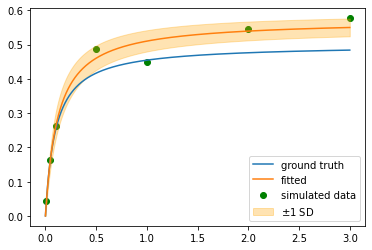

In [18]:
plt.plot(substrate_concentration_range, mm_curve,
         label='ground truth')
plt.scatter(substrate_concentrations, simulated_noisy_data,
            label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve,
         label='fitted')

plus_one_std = michaelis_menten(substrate_concentration_range,
                                fitted[0]-perr[0],
                                fitted[1]+perr[1])
minus_one_std = michaelis_menten(substrate_concentration_range,
                                 fitted[0]+perr[0],
                                 fitted[1]-perr[1])
plt.fill_between(substrate_concentration_range,
                 plus_one_std, minus_one_std,
                 alpha=0.3,
                 color='orange',
                 label='$\pm$1 SD')

plt.legend();

## Uncertainty

In the fit above, we used the covariance matrix to determine the error bounds.  What's not so apparent from this is that this only works for some fitting algorithm (including linear least-squares - by-far the most commonly used fitting algorithm), is only valid if the errors are normally distributed, and is then only valid if the data is homoscedastic (the measurement error is the same for every point - which isn't really true in this case!)  

So what are we to do?
1.  Work out the analytical error for every fit, assuming the characteristics of the error (hard - lots of algebra)
2.  Use resampling to empirically determine the distribution of parameter values (hard - lots of computation)

Except #2 isn't hard - we have computers to do the computation for us.  The type of resampling we'll be doing is call bootstrapping.  The mathematical justification for why this works is (way) beyond this course.  But the important result is that, if you follow a few rules, you can approximate the actual underlying distribution on almost any parameter, and then extract what you want directly.  Here are the rules:
1. Generate a new set of data by sampling, with replacement, from your current data set.
2. The new data set must have the same number of observations as the original (some data will get repeated, some left out)
3. Fit your curve with the new dataset
4. Repeat a few hundred to tens of thousands of times until the distribution stabilizes

An example in code should make this clear:

In [19]:
def make_bootstrap_sample(original_sample_x, original_sample_y):
    assert len(original_sample_x) == len(original_sample_y)
    indices = np.arange(len(original_sample_x)-1)
    resample_indices = np.random.choice(indices, size=len(indices), replace=True)
    resampled_x = original_sample_x[resample_indices]
    resampled_y = original_sample_y[resample_indices]
    return resampled_x, resampled_y

In [32]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
initial_guess = (1, simulated_noisy_data[-1])  # Km and Vmax.

bootstrap_values =[]

iterations = 1000

for _ in range(iterations):
    # Generate new sample indices with replacement 
    resampled_s, resampled_d = make_bootstrap_sample(substrate_concentrations, simulated_noisy_data)
    
    # Fit the curve with the resampled dataset
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=resampled_s,
                                                       ydata=resampled_d,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    bootstrap_values.append(bootstrap_fitted)
    
bootstrap_kms = tuple(v[0] for v in bootstrap_values)
bootstrap_vmaxs = tuple(v[1] for v in bootstrap_values)

Now look at the results

1000

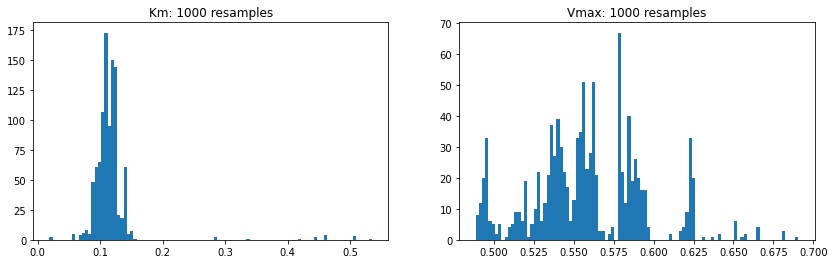

In [33]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(bootstrap_kms, bins=100)
# plt.xlim(0,1)
plt.title(f'Km: {len(bootstrap_kms)} resamples')

plt.subplot(122)
plt.hist(bootstrap_vmaxs, bins=100)
# plt.xlim(0,2)
plt.title(f'Vmax: {len(bootstrap_vmaxs)} resamples');

len(bootstrap_kms)

Notice that the plots above aren't that smooth, and have some outliers.  Lets repeat the bootstrap with 10 000 iterations (start this running now, while you read the instructions for Exercise 3.)

10000

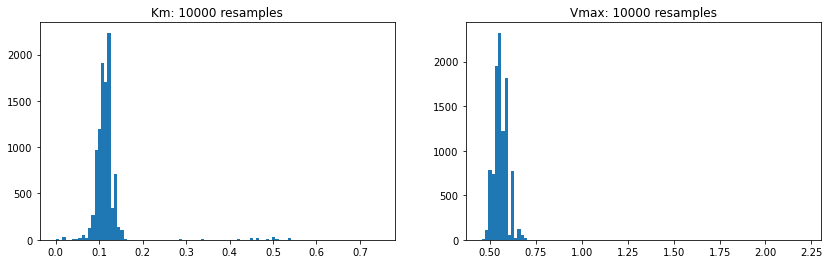

In [34]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
initial_guess = (1, simulated_noisy_data[-1])  # Km and Vmax.

bootstrap_values =[]

iterations = 10000

for _ in range(iterations):
    # Generate new sample indices with replacement 
    resampled_s, resampled_d = make_bootstrap_sample(substrate_concentrations, simulated_noisy_data)
    
    # Fit the curve with the resampled dataset
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=resampled_s,
                                                       ydata=resampled_d,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    bootstrap_values.append(bootstrap_fitted)
    
bootstrap_kms = tuple(v[0] for v in bootstrap_values)
bootstrap_vmaxs = tuple(v[1] for v in bootstrap_values)
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(bootstrap_kms, bins=100)
# plt.xlim(0,1)
plt.title(f'Km: {len(bootstrap_kms)} resamples')

plt.subplot(122)
plt.hist(bootstrap_vmaxs, bins=100)
# plt.xlim(0,2)
plt.title(f'Vmax: {len(bootstrap_vmaxs)} resamples');

len(bootstrap_kms)

### Exercise 3: Confidence interval
The 90% confidence interval is the range of values that contain the central 90% of the distribution.  Extract the 90%  CI for the data above.
1. Make sure you've started the 10 000 iterations above.
2. Make sorted listes of bootstrap_kms and bootstrap_vmaxs
3. If you have 10000 sorted data points, the central 9000 data points make up your 90% CI - extract the lowest and hightest values from these 9000
4. Use `plt.scatter` to plot all 10000 points.  What do you notice?
4. Eliminate any datapoint with $K_m$ or $Vmax$ values outside the 90% central data, and polt these points.  What do you notice?
5. Make two plots comparing the fitting error to the 90% CI.  First, plot the $K_m$ CI using the originally fitted $V_{max}$, then plot the $V_{max}$ CI using the originally fitted $K_m$.

In [37]:
CI = 0.9

sorted_bootstrap_kms = sorted(bootstrap_kms)
sorted_bootstrap_vmaxs = sorted(bootstrap_vmaxs)

low_CI_index = int((len(sorted_bootstrap_kms) * (1-CI)/2))
high_CI_index = -1*low_CI_index

low_km = sorted_bootstrap_kms[low_CI_index]
high_km = sorted_bootstrap_kms[high_CI_index]
low_vmax = sorted_bootstrap_vmaxs[low_CI_index]
high_vmax = sorted_bootstrap_vmaxs[high_CI_index]

print('The {}% CI for Km is {:0.3} to {:0.3}'
      .format((CI*100), low_km, high_km))
print('The {}% CI for Vmax is {:0.3} to {:0.3}'
      .format((CI*100), low_vmax, high_vmax))

The 90.0% CI for Km is 0.0884 to 0.14
The 90.0% CI for Vmax is 0.496 to 0.624


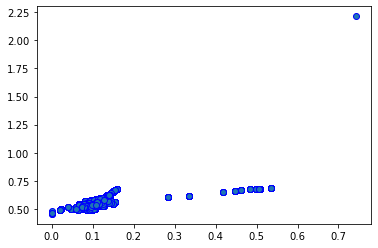

In [39]:
plt.scatter(bootstrap_kms, bootstrap_vmaxs, edgecolors='b', facecolors=None)

In [45]:
central_bootstrap_values = []
for value in bootstrap_values:
    if low_km < value[0] < high_km:
        if low_vmax < value[1] < high_vmax:
            central_bootstrap_values.append(value)
central_bootstrap_kms = tuple(v[0] for v in central_bootstrap_values)
central_bootstrap_vmaxs = tuple(v[1] for v in central_bootstrap_values)

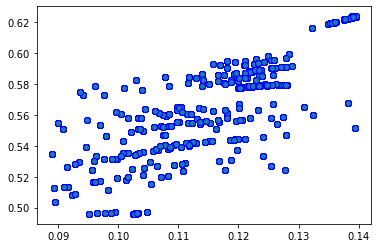

In [46]:
plt.scatter(central_bootstrap_kms, central_bootstrap_vmaxs,
            edgecolors='b', facecolors=None)

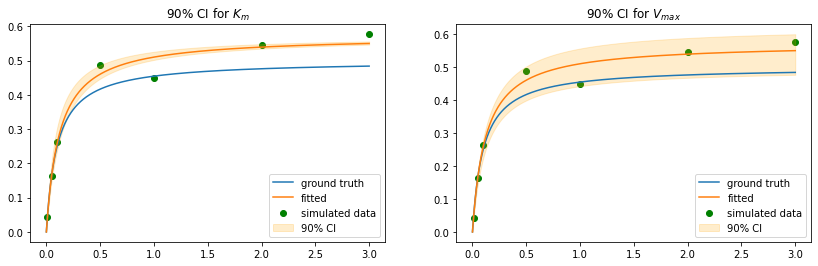

In [47]:
plt.figure(figsize=(14,4))

plt.subplot(121)
plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='fitted')

plus_one_CI = michaelis_menten(substrate_concentration_range,
                               sorted_bootstrap_kms[low_CI_index], fitted[1])
minus_one_CI = michaelis_menten(substrate_concentration_range,
                                sorted_bootstrap_kms[high_CI_index], fitted[1])
plt.fill_between(substrate_concentration_range, plus_one_CI, minus_one_CI,
                 alpha=0.2, color='orange', label='90% CI')
plt.title('90% CI for $K_m$')
plt.legend();

plt.subplot(122)
plt.plot(substrate_concentration_range, mm_curve, label='ground truth')
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='fitted')

plus_one_CI = michaelis_menten(substrate_concentration_range,
                               fitted[0], sorted_bootstrap_vmaxs[low_CI_index])
minus_one_CI = michaelis_menten(substrate_concentration_range,
                                fitted[0], sorted_bootstrap_vmaxs[high_CI_index])
plt.fill_between(substrate_concentration_range, plus_one_CI, minus_one_CI,
                 alpha=0.2, color='orange', label='90% CI')
plt.title('90% CI for $V_{max}$')
plt.legend();


One thing to note here:  The confidence intervals *are not centered on the prediction*, this means that, given our data, we're more certain about one bound than the other.  Because we've used random noise, your intervals may appear centered, but if you run the notebook again, you may be able to see that they're not.

So what's going on here?  Why did our "Fitting Error" above give us a single bound centered on the data?  The covariance matrix method assumes the data is normally distributed - so the error with be the same both 'above' and 'below' the true value.  It also assumes that the X and Y values are NOT correlated - which they are here.  

So which to use?  If you want to know how good the program fit your data, use the covariance method.  If you want to know how well your experiment's determined the true parameters, use the bootstrap.  It really is that simple.

Finally - what can we do to improve our precision?

### Exercise 4: Experimental replicates
Most experiments will have replicate data points, i.e. the researcher measures the initial rate several times at each substrate concentration.
1. Create a new list of substrate concentrations called `substrate_concentrations_with_replicates`, using each concentration three times (order doesn't matter)
2. Create new simulated data called `simulated_data_with_replicates` from above, adding the same *amount* of random noise (but not the same set of random numbers) as for `simulated_noisy_data`
3. Fit the data and calculate the 90% CI with the replicates.  Make plots of the distributions.
What do you notice?

In [48]:
substrate_concentrations_with_replicates = np.array([0.01, 0.05, 0.1, 0.5, 1, 2, 3,
                                                     0.01, 0.05, 0.1, 0.5, 1, 2, 3,
                                                     0.01, 0.05, 0.1, 0.5, 1, 2, 3])
noise = (np.random.normal(loc=1, scale=0.1, size=len(substrate_concentrations_with_replicates)))
simulated_data_with_replicates = michaelis_menten(substrate_concentrations_with_replicates, km, vmax,) * noise

In [50]:
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
initial_guess = (1, simulated_data_with_replicates[-1])  # Km and Vmax.

bootstrap_values_with_replicates = []

iterations = 10000

for _ in range(iterations):
    # Generate new sample indices with replacement 
    indices = np.arange(len(substrate_concentrations_with_replicates)-1)
    resample_indices = np.random.choice(indices, size=len(indices), replace=True)
    resampled_substrate_concentrations_with_replicates = substrate_concentrations_with_replicates[resample_indices]
    resampled_simulated_data_with_replicates = simulated_data_with_replicates[resample_indices]
    
    # Fit the curve with the resampled dataset
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=resampled_substrate_concentrations_with_replicates,
                                                       ydata=resampled_simulated_data_with_replicates,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    bootstrap_values_with_replicates.append(bootstrap_fitted)
    
bootstrap_kms_with_replicates = tuple(v[0] for v in bootstrap_values_with_replicates)
bootstrap_vmaxs_with_replicates = tuple(v[1] for v in bootstrap_values_with_replicates)

10000

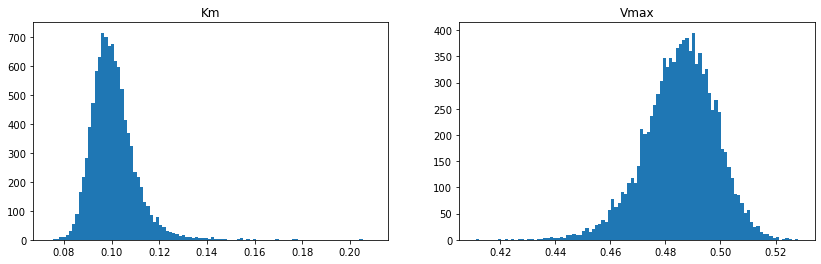

In [51]:
plt.figure(figsize=(14, 4))

plt.subplot(121)
plt.hist(bootstrap_kms_with_replicates, bins=100)
# plt.xlim(0,1)
plt.title('Km')

plt.subplot(122)
plt.hist(bootstrap_vmaxs_with_replicates, bins=100)
# plt.xlim(0,2)
plt.title('Vmax');

len(bootstrap_kms)

In [52]:
CI = 0.9

sorted_bootstrap_kms_with_replicates = sorted(bootstrap_kms_with_replicates)
sorted_bootstrap_vmaxs_with_replicates = sorted(bootstrap_vmaxs_with_replicates)

low_CI_index = int((len(sorted_bootstrap_kms_with_replicates) * (1-CI)/2))
high_CI_index = -1*low_CI_index

print('The {}% CI for Km is {:0.3} to {:0.3}'
      .format((CI*100),
              sorted_bootstrap_kms_with_replicates[low_CI_index],
              sorted_bootstrap_kms_with_replicates[high_CI_index]
             ))
print('The {}% CI for Vmax is {:0.3} to {:0.3}'
      .format((CI*100),
              sorted_bootstrap_vmaxs_with_replicates[low_CI_index],
              sorted_bootstrap_vmaxs_with_replicates[high_CI_index]
             ))

The 90.0% CI for Km is 0.0883 to 0.117
The 90.0% CI for Vmax is 0.463 to 0.505


## Model choice

One common difficulty in analysing data is choosing the correct model.  The most tempting choice is the model that fits our data best - *this is extremely dangerous.*  Here's the equation for homotropic alosterism (substrate activation or inhibition of the enzyme):  

$$\large V = \frac{V_{max}\frac{[S]}{K_{D1}} + \beta V_{max}\frac{[S]^2}{\alpha K_{D1}K_{D12}}}{1 + \frac{[S]}{K_{D1}} + \frac{[S]}{K_{D2}} + \frac{[S]^2}{\alpha K_{D1} K_{D2}}}$$  

Now, **we know that our system doesn't have any substrate inhibition or activation** - we created the data afterall - but lets see how this does...

In [53]:
def michaelis_menten_ha(s, kd1, kd2, alpha, beta, vmax):
    '''
    The Michaelis-Menton function including homotropic allosterism. 
    '''
    numerator = vmax * (s/kd1) + (beta * vmax * (s**2)/(alpha * kd1 *kd2))
    denominator = 1 + (s/kd1) + (s/kd2) + (s**2)/(alpha * kd1 * kd2)
    
    return numerator/denominator

If we set $\alpha$ and $\beta$ to be 1, and set $K_{D1}$ and $K_{D2}$ to the same value, the equation above reduces to the standard Michaelis-Menton equation, so we'll set our starting parameters there.

In [54]:
initial_guess = (fitted[0], fitted[0], 1, 1, fitted[1])  # KD1, KD2, alpha, beta and Vmax
lower_bounds_ha = (0, 0, 0, 0, 0)
upper_bounds_ha = (np.inf, np.inf, np.inf, np.inf, np.inf)

fitted_ha, covariance_ha = curve_fit(f=michaelis_menten_ha,
                               xdata=substrate_concentrations,
                               ydata=simulated_noisy_data,
                               p0=initial_guess,
                               bounds=(lower_bounds_ha, upper_bounds_ha)
                              )

print('Original Michaelis-Menton')
print('Km:', fitted[0])
print('Vmax:',fitted[1])

print()

print('Michaelis-Menton with aditional parameters')
print('KD1', fitted_ha[0])
print('KD2:',fitted_ha[1])
print('alpha:', fitted_ha[2])
print('beta:',fitted_ha[3])
print('Vmax:', fitted_ha[4])

Original Michaelis-Menton
Km: 0.12155184654224974
Vmax: 0.572158332397495

Michaelis-Menton with aditional parameters
KD1 0.10057515030005666
KD2: 630.2266123189905
alpha: 379.0298609735022
beta: 10362.602024391535
Vmax: 0.522639636598572


Ok, so now which one fits our data better?

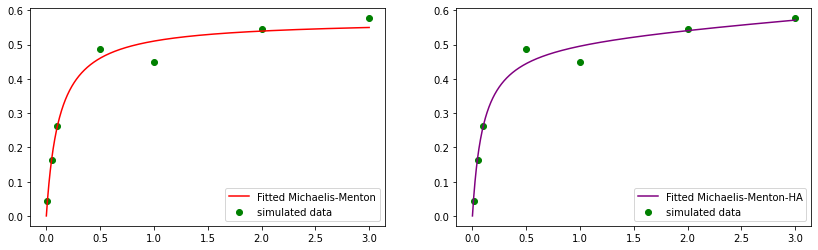

In [55]:
calculated_curve_ha = michaelis_menten_ha(substrate_concentration_range,
                                          *fitted_ha)  # *fitted_ha => fitted_ha[0], fitted_ha[1]

plt.figure(figsize=(14,4))

plt.subplot(121)
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve, label='Fitted Michaelis-Menton', color='red')
plt.legend(loc='lower right')

plt.subplot(122)
plt.scatter(substrate_concentrations, simulated_noisy_data, label='simulated data', color='green')
plt.plot(substrate_concentration_range, calculated_curve_ha, label='Fitted Michaelis-Menton-HA', color='purple')
plt.legend(loc='lower right');

Which one do you think looks better?

So what does this mean?  Because the  `michaelis_menten_ha` function is the `michaelis_menten` function with three extra parameters, it will **always** fit noisy data better.  Because we used the `michaelis_menten` function to generate the data, we know that's the one we should actually be using, though.  If you're faced with a real-world problem, and the function with more parameters will always fit noisy data better, how can you tell if you really should use the function with more parameters or not?

## Model selection by cross validation

How do you know which model to choose?  One of the best ways is cross-validation.  The key to undersanding why this is so powerful is that cross-validation essentially tests how much of the random noise you're modelling.  The function that models the least noise and most signal is almost always the correct one. 

Cross-validation leaves a bit of data out, then fits (trains) the curve without that data, then tests how well the left out data is predicted by the fit.

We'll start with leave-one-out cross validation:

In [56]:
initial_guess = (100, simulated_noisy_data[-1])  # Km and Vmax.  Note the Km is a truly horrible guess, given our data
lower_bounds = (0, 0)  # Km, Vmax
upper_bounds = (np.inf, np.inf)  # Km, Vmax
predictions = []

# Step through each substrate concentration
for i in range(len(substrate_concentrations)):
    
    # Build a mask excluding the test measurement
    mask = np.ones(len(substrate_concentrations)).astype('bool')
    mask[i] = False
    
    # Remove the test measurement from our training data
    training_substrate_concentrations = substrate_concentrations[mask]
    training_simulated_data = simulated_noisy_data[mask]
    
    # Fit the curve
    bootstrap_fitted, bootstrap_covariance = curve_fit(f=michaelis_menten,
                                                       xdata=training_substrate_concentrations,
                                                       ydata=training_simulated_data,
                                                       p0=initial_guess,
                                                       bounds=(lower_bounds, upper_bounds)
                                                      )
    predictions.append(michaelis_menten(substrate_concentrations[i], *fitted))

abs_errors = abs(predictions - simulated_noisy_data)
xval_error = sum(abs_errors)
print("Cross validation error for 'michaelis_menten':",xval_error)

Cross validation error for 'michaelis_menten': 0.12845147407047391


### Exercise 5: Model selection by cross validation
Run the cross validation on `michaelis_menten_ha`.  Which function gives lower cross-validation error?  

*Hint: If you get `Optimal parameters not found` error, add the parameter `max_nfev=10000` to the `curve_fit` call.*


In [57]:
initial_guess = (fitted[0], fitted[0], 1, 1, fitted[1])  # KD1, KD2, alpha, beta and Vmax
lower_bounds_ha = (0, 0, 0, 0, 0)  # Km, Vmax
upper_bounds_ha = (np.inf, np.inf, np.inf, np.inf, np.inf)  # Km, Vmax
predictions = []

# Step through each substrate concentration
for i in range(len(substrate_concentrations)):
    
    # Build a mask excluding the test measurement
    mask = np.ones(len(substrate_concentrations)).astype('bool')
    mask[i] = False
    
    # Remove the test measurement from our training data
    training_substrate_concentrations = substrate_concentrations[mask]
    training_simulated_data = simulated_noisy_data[mask]
    
    # Fit the curve
    fitted_ha, covariance_ha = curve_fit(f=michaelis_menten_ha,
                                   xdata=training_substrate_concentrations,
                                   ydata=training_simulated_data,
                                   p0=initial_guess,
                                   bounds=(lower_bounds_ha, upper_bounds_ha),
                                   max_nfev=10000
                                  )
    predictions.append(michaelis_menten_ha(substrate_concentrations[i], *fitted_ha))

abs_errors = abs(predictions - simulated_noisy_data)
xval_ha_error = sum(abs_errors)
print("Cross validation error for 'michaelis_menten_ha':",xval_ha_error)

Cross validation error for 'michaelis_menten_ha': 0.25053578477345595


So which model do we choose?

In [59]:
xval_ratio = xval_error / xval_ha_error

if xval_ratio < 0.95:
    print('Michaelis-Menton is the prefered model.')
elif 1/xval_ratio < 0.95:
    print('Michaelis-Menton with Homotropic Alostery is the prefered model.')
else:
    print("The cross validation scores are too close, we can't descriminiate between the models")

Michaelis-Menton is the prefered model.


As always, there are lots of choices for how exactly we do cross-validation, but here are the two most import issues:

1. If you only have a few more observations than parameters, do leave-one-out validation.
2. If you have correlated data (i.e. several blocks of data,) try to keep the correlated data either in the test or training sets  

In general, if you have many more data points than parameters, you can do k-fold cross validation.  For example, with 5-fold cross-validation, you would split your data into 5 chunks, using 4 of the chunks for training and one for error determination.  As you have 5 chunks, you do it 5 times (using a different chunk each time,) and sum up the errors.  The model with the lowest error is the one over-fitting the least.